In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from PIL import Image 
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force TensorFlow to use CPU
# Проверка, что GPU не используется:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  # Должно вывести 0

Num GPUs Available:  0


In [4]:
def parse_annotation(xml_path):
    """Извлекает данные из XML-файла"""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    boxes = []
    labels = []
    
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)
    
    return boxes, labels

In [7]:
def create_label_map(labels_list):
    """Создаёт словарь классов с индексами"""
    unique_labels = sorted(set(labels_list))
    return {name: i+1 for i, name in enumerate(unique_labels)}  # +1 для фона
def labels_to_indices(labels, label_map):
    """Конвертирует текстовые метки в числовые индексы"""
    return np.array([label_map[l] for l in labels], dtype=np.int32)

In [9]:
def load_data(image_dir, annotation_dir):
    """Загружает все метки из аннотаций"""
    all_labels = []
    for image_name in os.listdir(image_dir):
        if image_name.endswith('.jpg'):
            xml_path = os.path.join(annotation_dir, image_name.replace('.jpg', '.xml'))
            _, labels = parse_annotation(xml_path)
            all_labels.extend(labels)
    return all_labels

In [11]:
def data_generator(image_dir, annotation_dir, batch_size, img_size, label_map, num_boxes=600):
    """Генератор батчей с паддингом"""
    image_names = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    np.random.shuffle(image_names)
    num_classes = len(label_map) + 1
    
    while True:
        batch_images = []
        batch_boxes = []
        batch_labels = []
        
        for image_name in image_names:
            # Загрузка изображения
            img = Image.open(os.path.join(image_dir, image_name)).convert('RGB').resize(img_size)
            img_array = np.array(img) / 255.0
            
            # Загрузка аннотаций
            xml_path = os.path.join(annotation_dir, image_name.replace('.jpg', '.xml'))
            boxes, labels = parse_annotation(xml_path)
            
            # Нормализация координат
            boxes = np.array(boxes, dtype=np.float32)
            boxes[:, [0, 2]] /= img_size[0]
            boxes[:, [1, 3]] /= img_size[1]
            
            # Конвертация меток
            label_indices = labels_to_indices(labels, label_map)
            
            batch_images.append(img_array)
            batch_boxes.append(boxes)
            batch_labels.append(label_indices)
            
            if len(batch_images) == batch_size:
                # Паддинг
                padded_boxes = np.zeros((batch_size, num_boxes, 4), dtype=np.float32)
                padded_labels = np.zeros((batch_size, num_boxes, num_classes), dtype=np.float32)
                
                for i in range(batch_size):
                    num = min(len(batch_boxes[i]), num_boxes)
                    padded_boxes[i, :num] = batch_boxes[i][:num]
                    padded_labels[i, :num] = tf.one_hot(batch_labels[i][:num], num_classes).numpy()
                
                yield np.array(batch_images), [padded_boxes, padded_labels]
                
                batch_images = []
                batch_boxes = []
                batch_labels = []

In [13]:
# Ячейка 5: Архитектура модели
def build_ssd_model(input_shape, num_classes):
    """Создаёт SSD модель"""
    input_tensor = tf.keras.Input(shape=input_shape)
    
    # Базовая CNN
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same')(input_tensor)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Ветка для боксов
    box_output = tf.keras.layers.Dense(num_boxes * 4)(x)
    box_output = tf.keras.layers.Reshape((num_boxes, 4))(box_output)
    
    # Ветка для классов
    class_output = tf.keras.layers.Dense(num_boxes * num_classes)(x)
    class_output = tf.keras.layers.Reshape((num_boxes, num_classes))(class_output)
    
    return tf.keras.Model(inputs=input_tensor, outputs=[box_output, class_output])

In [15]:
# Ячейка 6: Кастомные потери
class SSDLoss(tf.keras.losses.Loss):
    """Комбинированная функция потерь для SSD"""
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
    def call(self, y_true, y_pred):
        # Используем индексацию вместо распаковки
        true_boxes = y_true[0]  # Координаты боксов
        true_labels = y_true[1]  # One-hot метки классов
        
        pred_boxes = y_pred[0]  # Предсказанные координаты боксов
        pred_classes = y_pred[1]  # Предсказанные метки классов
        
        # Потери для боксов (Smooth L1 Loss)
        box_diff = tf.abs(true_boxes - pred_boxes)
        box_loss = tf.reduce_mean(
            tf.where(box_diff < 1.0, 0.5 * tf.square(box_diff), box_diff - 0.5)
        )
        
        # Потери для классов (Categorical Crossentropy)
        cls_loss = tf.reduce_mean(
            tf.keras.losses.categorical_crossentropy(true_labels, pred_classes)
        )
        
        return box_loss + cls_loss


In [17]:
def visualize_predictions(model, image_dir, annotation_dir, label_map, img_size=(300, 300), num_examples=4):
    """Визуализация предсказаний модели"""
    image_names = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    np.random.shuffle(image_names)
    
    # Ограничиваем количество примеров
    num_examples = min(len(image_names), num_examples)
    
    plt.figure(figsize=(12, 8))  # Уменьшенные размеры графика
    
    for i in range(num_examples):
        img_path = os.path.join(image_dir, image_names[i])
        img = Image.open(img_path).convert('RGB').resize(img_size)
        img_array = np.array(img) / 255.0
        
        pred_boxes, pred_classes = model.predict(img_array[np.newaxis, ...])
        pred_boxes = pred_boxes[0]  # Убираем batch dimension
        pred_scores = tf.reduce_max(pred_classes[0], axis=1)  # Уверенность модели
        
        plt.subplot(2, 2, i+1)
        plt.imshow(img)
        plt.title(f"Предсказание {image_names[i]}")
        
        # Предсказанные боксы (красные)
        for box, score in zip(pred_boxes, pred_scores):
            if score < 0.5:  # Порог уверенности
                continue
            xmin, ymin, xmax, ymax = box * img_size[0]
            xmin = max(0, xmin)  # Ограничиваем координаты
            ymin = max(0, ymin)
            xmax = min(img_size[0], xmax)
            ymax = min(img_size[1], ymax)
            
            plt.gca().add_patch(plt.Rectangle(
                (xmin, ymin), xmax-xmin, ymax-ymin,
                linewidth=2, edgecolor='r', facecolor='none'
            ))
            class_id = np.argmax(score)
            if class_id > 0:
                plt.text(xmin, ymin-10,
                         f"{list(label_map.keys())[class_id-1]} {score:.2f}",
                         color='red', fontsize=8)
    
    plt.tight_layout()  # Попробуем подогнать макет
    plt.show()

Создаем маппинг классов...
Создан label_map: {'Platelets': 1, 'RBC': 2, 'WBC': 3}

Создаем модель...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 300, 300,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 150, 150,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 150, 150,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 75, 75,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_1[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2400)      │    156,000 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2400)      │    156,000 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 600, 4)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 600, 4)    │          0 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 331,392 (1.26 MB)

 Trainable params: 331,392 (1.26 MB)

 Non-trainable params: 0 (0.00 B)


Компилируем модель...

Визуализация примеров данных:


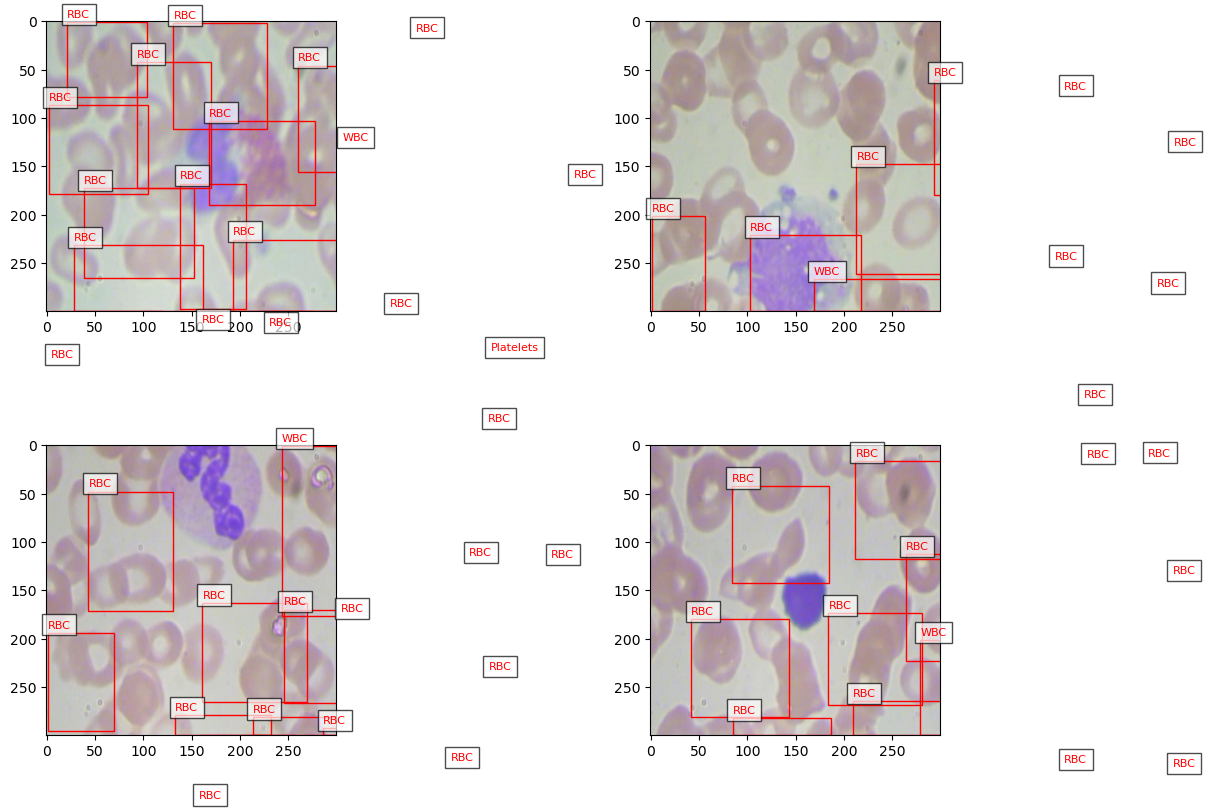


Начало обучения...

Эпоха 1/10
Шаг 001, Loss: 1.5996
Шаг 011, Loss: 1.4595
Шаг 021, Loss: 1.5717
Шаг 031, Loss: 1.6140
Шаг 041, Loss: 1.5954
Шаг 051, Loss: 1.5834
Модель сохранена (epoch 1)

Эпоха 2/10
Шаг 001, Loss: 1.5776
Шаг 011, Loss: 1.5656
Шаг 021, Loss: 1.5368
Шаг 031, Loss: 1.5405
Шаг 041, Loss: 1.5408
Шаг 051, Loss: 1.5407
Модель сохранена (epoch 2)

Эпоха 3/10
Шаг 001, Loss: 1.5426
Шаг 011, Loss: 1.5358
Шаг 021, Loss: 1.5288
Шаг 031, Loss: 1.5161
Шаг 041, Loss: 1.4853
Шаг 051, Loss: 1.4622
Модель сохранена (epoch 3)

Эпоха 4/10
Шаг 001, Loss: 1.4592
Шаг 011, Loss: 1.4335
Шаг 021, Loss: 1.4284
Шаг 031, Loss: 1.4161
Шаг 041, Loss: 1.4095
Шаг 051, Loss: 1.4029
Модель сохранена (epoch 4)

Эпоха 5/10
Шаг 001, Loss: 1.4005
Шаг 011, Loss: 1.3961
Шаг 021, Loss: 1.3874
Шаг 031, Loss: 1.3702
Шаг 041, Loss: 1.3594
Шаг 051, Loss: 1.3472
Модель сохранена (epoch 5)

Эпоха 6/10
Шаг 001, Loss: 1.3457
Шаг 011, Loss: 1.3512
Шаг 021, Loss: 1.3487
Шаг 031, Loss: 1.3463
Шаг 041, Loss: 1.3425
Шаг

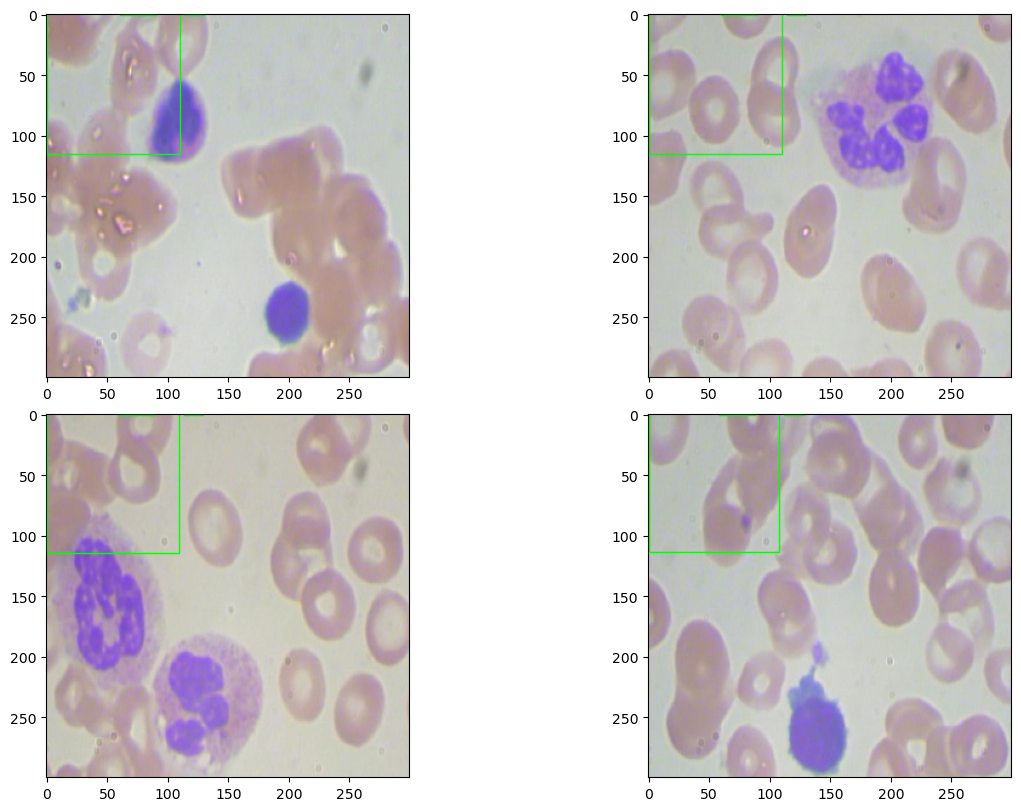

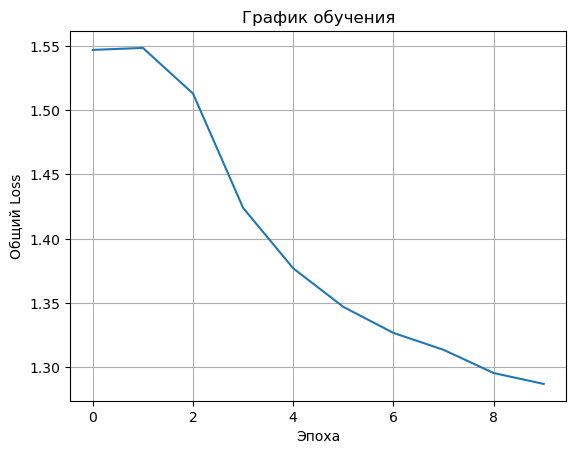

In [19]:
if __name__ == "__main__":
    # Параметры
    image_dir = "./BCCD_Dataset-master/BCCD/JPEGImages"
    annotation_dir = "./BCCD_Dataset-master/BCCD/Annotations"
    img_size = (300, 300)
    batch_size = 4
    num_boxes = 600

    # 1. Создание label_map
    print("Создаем маппинг классов...")
    all_labels = []
    for image_name in os.listdir(image_dir):
        if image_name.endswith('.jpg'):
            xml_path = os.path.join(annotation_dir, image_name.replace('.jpg', '.xml'))
            _, labels = parse_annotation(xml_path)
            all_labels.extend(labels)
    
    label_map = create_label_map(all_labels)
    print(f"Создан label_map: {label_map}")
    num_classes = len(label_map) + 1

    # 2. Инициализация модели
    print("\nСоздаем модель...")
    model = build_ssd_model(
        input_shape=(img_size[0], img_size[1], 3),
        num_classes=num_classes
    )
    model.summary()

    # 3. Компиляция модели
    print("\nКомпилируем модель...")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=SSDLoss(num_classes=num_classes)
    )

    # 4. Инициализация генератора данных
    train_gen = data_generator(
        image_dir=image_dir,
        annotation_dir=annotation_dir,
        batch_size=batch_size,
        img_size=img_size,
        label_map=label_map,
        num_boxes=num_boxes
    )

    # 5. Визуализация первого батча
    print("\nВизуализация примеров данных:")
    images, [boxes, labels] = next(train_gen)
    plt.figure(figsize=(12, 8), constrained_layout=True)
    
    for i in range(min(4, batch_size)):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i])
        
        # Отображение истинных боксов
        for box, label in zip(boxes[i], labels[i]):
            if np.all(box == 0): continue
            
            xmin = max(0, int(box[0] * img_size[0]))
            ymin = max(0, int(box[1] * img_size[1]))
            xmax = min(img_size[0], int(box[2] * img_size[0]))
            ymax = min(img_size[1], int(box[3] * img_size[1]))
            
            plt.gca().add_patch(plt.Rectangle(
                (xmin, ymin), xmax-xmin, ymax-ymin,
                linewidth=1, edgecolor='r', facecolor='none'
            ))
            
            class_id = np.argmax(label)
            if class_id > 0:
                plt.text(xmin, ymin-5, 
                        list(label_map.keys())[class_id-1], 
                        color='red', fontsize=8, 
                        bbox=dict(facecolor='white', alpha=0.7))
    
    plt.show()

    # 6. Обучение модели
    print("\nНачало обучения...")
    history = {'loss': []}
    
    for epoch in range(10):
        print(f"\nЭпоха {epoch+1}/10")
        epoch_loss = []
        
        for step, (images, [boxes, labels]) in enumerate(train_gen):
            # Обучение на одном батче
            losses = model.train_on_batch(images, [boxes, labels])
            
            # Обработка возвращаемых потерь
            total_loss = np.sum(losses) if isinstance(losses, (list, tuple)) else float(losses)
            epoch_loss.append(total_loss)
            
            # Логирование каждые 10 шагов
            if step % 10 == 0:
                print(f"Шаг {step+1:03d}, Loss: {total_loss:.4f}")
            
            # Ограничение для демонстрации
            if step >= 50:
                break
        
        # Сохранение модели в современном формате
        model.save(f"ssd_epoch_{epoch+1}.keras")
        history['loss'].append(np.mean(epoch_loss))
        print(f"Модель сохранена (epoch {epoch+1})")

    # 7. Визуализация результатов
    print("\nВизуализация предсказаний...")
    test_images, _ = next(train_gen)
    plt.figure(figsize=(12, 8), constrained_layout=True)
    
    for i in range(4):
        plt.subplot(2, 2, i+1)
        img = test_images[i]
        pred_boxes, pred_classes = model.predict(img[np.newaxis, ...])
        
        plt.imshow(img)
        for box, score in zip(pred_boxes[0], tf.reduce_max(pred_classes[0], axis=1)):
            if score < 0.5: continue
            
            xmin = max(0, int(box[0] * img_size[0]))
            ymin = max(0, int(box[1] * img_size[1]))
            xmax = min(img_size[0], int(box[2] * img_size[0]))
            ymax = min(img_size[1], int(box[3] * img_size[1]))
            
            plt.gca().add_patch(plt.Rectangle(
                (xmin, ymin), xmax-xmin, ymax-ymin,
                linewidth=1, edgecolor='lime', facecolor='none'
            ))
            
            class_id = np.argmax(score)
            if class_id > 0:
                plt.text(xmin, ymin-5, 
                        f"{list(label_map.keys())[class_id-1]} {score:.2f}",
                        color='lime', fontsize=8, 
                        bbox=dict(facecolor='black', alpha=0.7))
    
    plt.show()

    # 8. График обучения
    plt.plot(history['loss'])
    plt.title("График обучения")
    plt.xlabel("Эпоха")
    plt.ylabel("Общий Loss")
    plt.grid(True)
    plt.show()